In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
import pandas as pd

# Specify the path to the ZIP file
zip_file_path = r"/content/drive/MyDrive/lung disease.zip"
# Specify the directory where you want to extract the contents
extracted_dir_path = r'C:\Users\karth\Downloads\lung_disease_extracted'

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# Generate data paths with labels
filepaths = []
labels = []

# Iterate through the extracted directories
for root, dirs, files in os.walk(extracted_dir_path):
    for f in files:
        # Get the full file path
        fpath = os.path.join(root, f)
        filepaths.append(fpath)

        # Determine the label based on the directory name
        folder_name = os.path.basename(root)
        if folder_name == 'colon_aca':
            labels.append('Colon Adenocarcinoma')
        elif folder_name == 'colon_n':
            labels.append('Colon Benign Tissue')
        elif folder_name == 'lung_aca':
            labels.append('Lung Adenocarcinoma')
        elif folder_name == 'lung_n':
            labels.append('Lung Benign Tissue')
        elif folder_name == 'lung_scc':
            labels.append('Lung Squamous Cell Carcinoma')

# Concatenate data paths with labels into one dataframe
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Optionally, you can clean up the extracted directory after you're done processing
# Note: Be cautious with this step, as it deletes the extracted files
# import shutil
# shutil.rmtree(extracted_dir_path)


In [ ]:
df


filepaths                labels
0      C:\Users\karth\Downloads\lung_disease_extracte...   Lung Adenocarcinoma
1      C:\Users\karth\Downloads\lung_disease_extracte...   Lung Adenocarcinoma
2      C:\Users\karth\Downloads\lung_disease_extracte...   Lung Adenocarcinoma
3      C:\Users\karth\Downloads\lung_disease_extracte...   Lung Adenocarcinoma
4      C:\Users\karth\Downloads\lung_disease_extracte...   Lung Adenocarcinoma
...                                                  ...                   ...
24995  C:\Users\karth\Downloads\lung_disease_extracte...  Colon Adenocarcinoma
24996  C:\Users\karth\Downloads\lung_disease_extracte...  Colon Adenocarcinoma
24997  C:\Users\karth\Downloads\lung_disease_extracte...  Colon Adenocarcinoma
24998  C:\Users\karth\Downloads\lung_disease_extracte...  Colon Adenocarcinoma
24999  C:\Users\karth\Downloads\lung_disease_extracte...  Colon Adenocarcinoma

[25000 rows x 2 columns]

In [ ]:
#Split data into train, valid, and test

In [ ]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [ ]:
# crobed image size
batch_size =64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 19983 validated image filenames belonging to 5 classes.
Found 2498 validated image filenames belonging to 5 classes.
Found 2498 validated image filenames belonging to 5 classes.


In [ ]:
#Show sample from train data

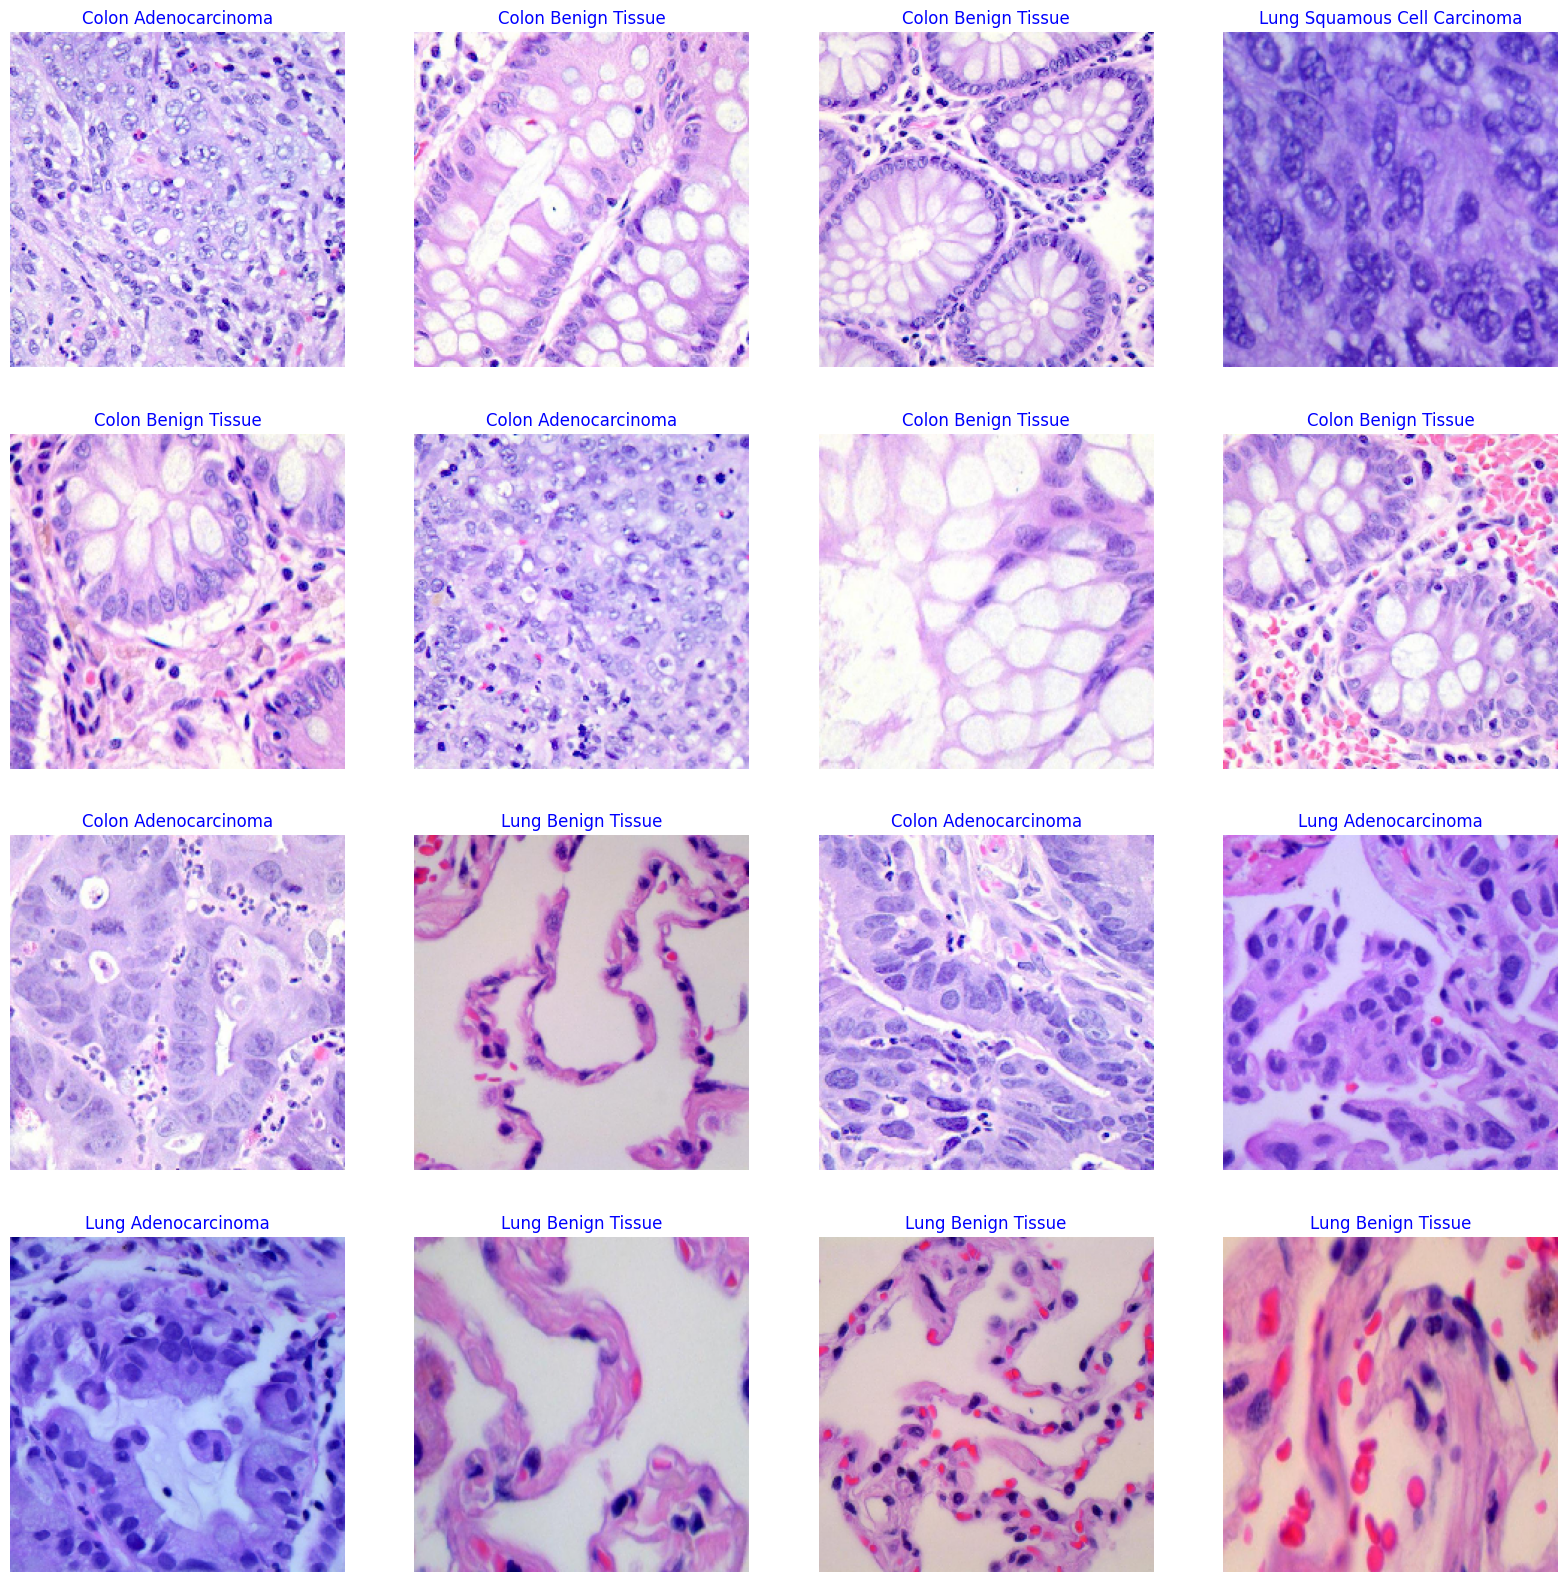

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
#Model Structure

2nd model

In [ ]:
#Generic Model Creation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU

# Define constants
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Define hyperparameters
learning_rate = 0.001
batch_size = 32
dropout_rate = 0.5
l2_reg = 0.001

# Create Model Structure
model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", input_shape= img_shape),
    LeakyReLU(alpha=0.1),
    Conv2D(filters=64, kernel_size=(3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(filters=128, kernel_size=(3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    Conv2D(filters=128, kernel_size=(3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(filters=256, kernel_size=(3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    Conv2D(filters=256, kernel_size=(3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    Conv2D(filters=256, kernel_size=(3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(filters=512, kernel_size=(3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    Conv2D(filters=512, kernel_size=(3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    Conv2D(filters=512, kernel_size=(3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(filters=512, kernel_size=(3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    Conv2D(filters=512, kernel_size=(3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    Conv2D(filters=512, kernel_size=(3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(256, kernel_regularizer=l2(l2_reg)),
    LeakyReLU(alpha=0.1),
    Dropout(dropout_rate),
    Dense(64, kernel_regularizer=l2(l2_reg)),
    LeakyReLU(alpha=0.1),
    Dropout(dropout_rate),
    Dense(class_count, activation="softmax")
])

# Experiment with different optimizers
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 112, 112, 64)      256       
 Normalization)                                         

In [ ]:
epochs = 12   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False,callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/12
313/313 [==============================] - 370s 1s/step - loss: 2.0450 - accuracy: 0.6030 - val_loss: 45.6230 - val_accuracy: 0.2432
Epoch 2/12
313/313 [==============================] - 301s 960ms/step - loss: 1.2955 - accuracy: 0.7177 - val_loss: 13.2899 - val_accuracy: 0.6096
Epoch 3/12
313/313 [==============================] - 300s 958ms/step - loss: 0.8393 - accuracy: 0.8152 - val_loss: 4.3308 - val_accuracy: 0.6668
Epoch 4/12
313/313 [==============================] - 300s 956ms/step - loss: 1.3299 - accuracy: 0.7295 - val_loss: 16.8812 - val_accuracy: 0.2852
Epoch 5/12
313/313 [==============================] - 299s 955ms/step - loss: 1.2508 - accuracy: 0.7758 - val_loss: 0.8683 - val_accuracy: 0.7860
Epoch 6/12
313/313 [==============================] - 300s 958ms/step - loss: 0.6902 - accuracy: 0.8458 - val_loss: 0.6934 - val_accuracy: 0.8072
Epoch 7/12
313/313 [==============================] - 300s 957ms/step - loss: 0.6146 - accuracy: 0.8683 - val_loss: 2.8512 -

In [ ]:
#Display model performance

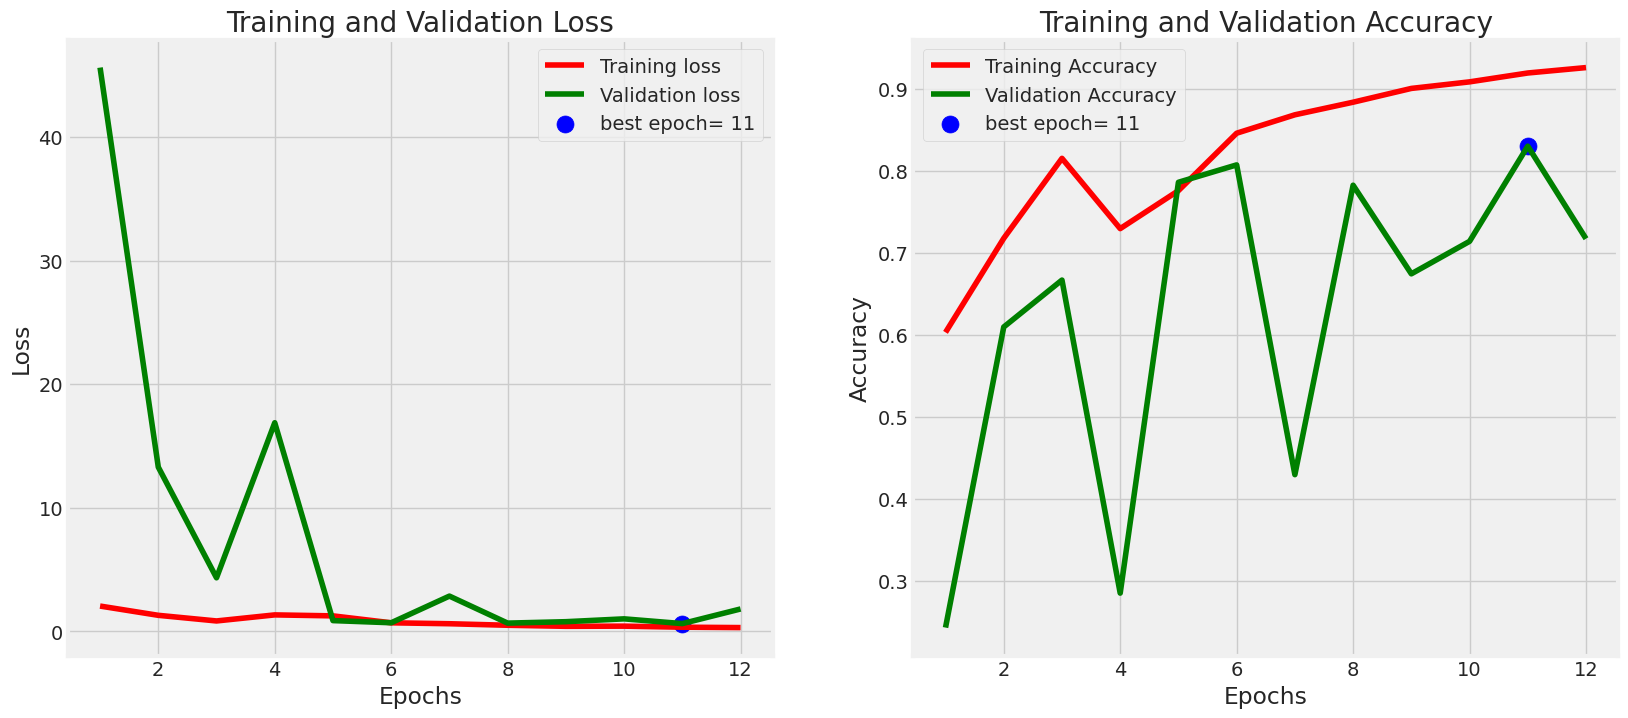

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
#Evaluate model

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

39/50 [======================>.......] - ETA: 4s - loss: 1.8348 - accuracy: 0.7039

39/50 [======================>.......] - ETA: 3s - loss: 1.8123 - accuracy: 0.7167

50/50 [==============================] - 14s 283ms/step - loss: 1.8097 - accuracy: 0.7172
Train Loss:  1.8797810077667236
Train Accuracy:  0.6971874833106995
--------------------
Valid Loss:  1.8332562446594238
Valid Accuracy:  0.7039999961853027
--------------------
Test Loss:  1.8097444772720337
Test Accuracy:  0.717199981212616


In [ ]:
#Get Predictions

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

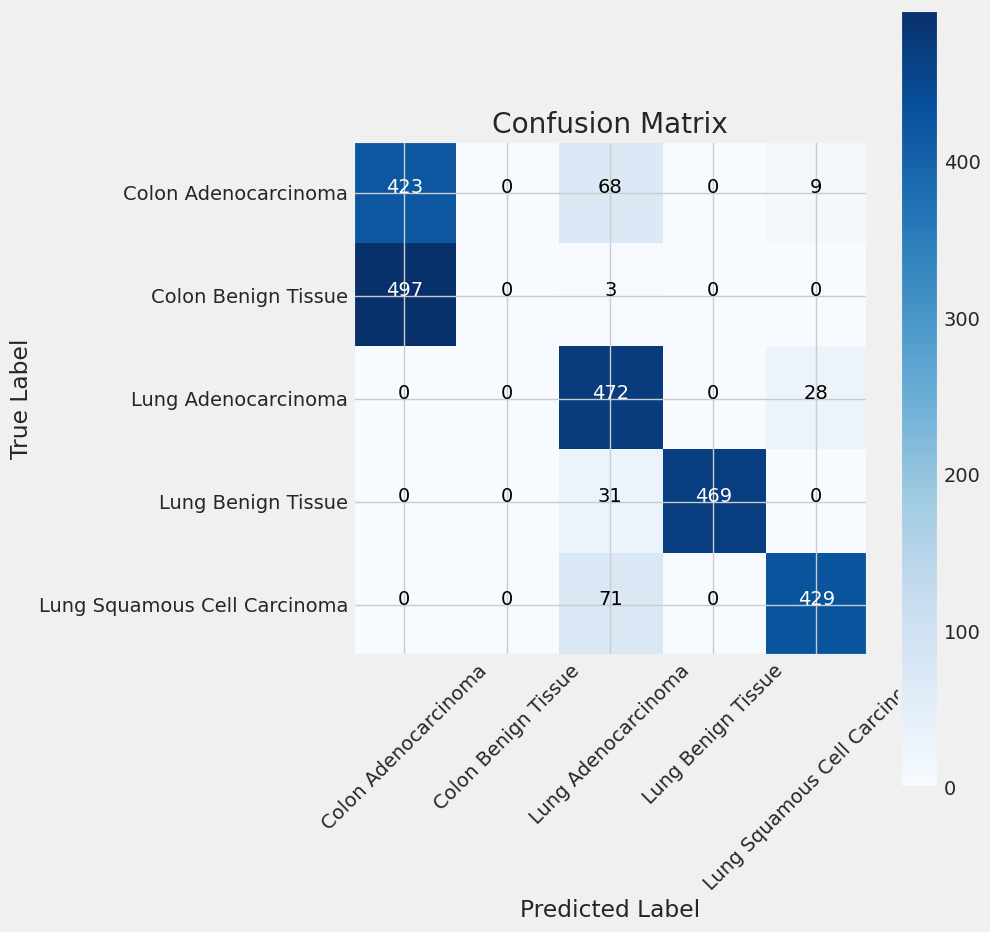

In [ ]:
import itertools
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       0.46      0.85      0.60       500
         Colon Benign Tissue       0.00      0.00      0.00       500
         Lung Adenocarcinoma       0.73      0.94      0.82       500
          Lung Benign Tissue       1.00      0.94      0.97       500
Lung Squamous Cell Carcinoma       0.92      0.86      0.89       500

                    accuracy                           0.72      2500
                   macro avg       0.62      0.72      0.66      2500
                weighted avg       0.62      0.72      0.66      2500



In [ ]:
#Save the model
model.save('/content/drive/MyDrive/CNN_Model_mod_param.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/CNN_Model_mod_param.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])


In [ ]:
image_path = '/content/colonca5000.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 1s 901ms/step
Colon Adenocarcinoma


In [ ]:
predictions

array([[9.9818486e-01, 1.3113572e-03, 4.0819083e-04, 9.5319556e-06,
        8.6191234e-05]], dtype=float32)

In [ ]:
image_path = '/content/lungn5000.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 2s 2s/step
Lung Benign Tissue


In [ ]:
predictions

array([[1.8253571e-16, 1.4547695e-15, 1.3156183e-16, 1.0000000e+00,
        1.1990355e-17]], dtype=float32)

In [ ]:
image_path = '/content/lungaca5000.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 1s 1s/step
Lung Adenocarcinoma


In [ ]:
predictions

array([[1.1592058e-09, 5.7561057e-12, 9.8639131e-01, 1.4134120e-04,
        1.3467347e-02]], dtype=float32)

In [ ]:
image_path = '/content/colonn5000.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 1s 1s/step
Colon Adenocarcinoma


In [ ]:
predictions

array([[9.9922824e-01, 7.1933208e-04, 4.1779662e-05, 2.3955997e-06,
        8.2220331e-06]], dtype=float32)

In [ ]:
image_path = '/content/lungscc5000.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 1s 862ms/step
Lung Adenocarcinoma


In [ ]:
predictions

array([[2.3971353e-07, 1.3568844e-09, 9.0194315e-01, 3.1685886e-05,
        9.8024912e-02]], dtype=float32)

In [ ]:
image_path = '/content/COLON.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 1s 773ms/step
Colon Adenocarcinoma


In [ ]:
predictions

array([[9.9878722e-01, 9.6891436e-04, 2.0029738e-04, 1.9014326e-05,
        2.4576299e-05]], dtype=float32)

In [ ]:
image_path = '/content/LUNG.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 1s 753ms/step
Lung Adenocarcinoma


In [ ]:
predictions

array([[3.1692521e-06, 3.2205822e-08, 9.0040994e-01, 2.1913736e-04,
        9.9367619e-02]], dtype=float32)

In [ ]:
print(score)